In [1]:
# 축구를 잘하는 사람이 족구도 잘한다.
# 요리를 잘하는 사람이 라면도 잘 끓인다
# 파이썬을 공부한 사람은 다른 언어를 잘 할 가능성이 많다.

In [2]:
# 딥러닝에도 적용
# 자연영상으로 학습한 신경망을 새나 개의 종을 분류하거나 자율주행에서 차선과 보행자 인식하는사용

In [3]:
# 어떤 도메인의 데이터로 학습한 모델을 다른 도메인의 데이터를 인식하는데 활용해서 성능 향상을 도모하는 기법
# cub200-2011 : 200종의 새 영상을 가지는데 부류별로 60장 밖에 안되서 과잉적합우려
# ImageNet으로 예비학습된 모델을 cub200-2011로 전이하는 전이학습

In [46]:
#ImageNet으로 학습된 ResNet50을 cub 데이터셋으로 전이 학습
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
import os

In [48]:
import zipfile
zippath = "/content/drive/MyDrive/CUB200/CUB200.zip"
zip_ref = zipfile.ZipFile(zippath,'r')
zip_ref.extractall('/content/drive/MyDrive/CUB200')  
zip_ref.close()
# !unzip -qq "/content/drive/MyDrive/CUB200/CUB200.zip"

In [49]:
class_reduce = 0.1
train_folder = "/content/drive/MyDrive/CUB200/train"
test_folder = "/content/drive/MyDrive/CUB200/test"

In [50]:
# 정답의 라벨수(부류의 갯수)
no_class = int(len(os.listdir(test_folder))*class_reduce)

In [ ]:
import glob
# 현재경로 뿐만 아니라 특정경로의 디렉터리명이나 확장자를 지정하면 해당 파일만
# 가져오는데 절대경로로 가져온다.
glob.glob(train_folder+"/*")

In [53]:
def convertXYData(foldername):
  x_train,y_train = [],[]
  for i, class_name in  enumerate(os.listdir(foldername)):        
    if i < no_class:      
      for fname in os.listdir(foldername+'/'+class_name):        
        img = image.load_img(foldername+'/'+class_name+'/'+fname,target_size=(224,224) )        
        if len(img.getbands()) != 3:
          print(f"유효하지 않은 영상발생 {class_name} {fname}")
          continue
        x = image.img_to_array(img)
        x = preprocess_input(x)
        x_train.append(x)
        y_train.append(i)
  return (x_train,y_train)

In [ ]:
x_train,y_train = convertXYData(train_folder)

In [54]:
x_test,y_test = convertXYData(test_folder)

In [56]:
np.array(x_train).shape, np.array(x_test).shape

((600, 224, 224, 3), (515, 224, 224, 3))

In [57]:
np.array(y_train).shape, np.array(y_test).shape

((600,), (515,))

In [60]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test =  np.asarray(x_test)
y_test = np.asarray(y_test)

In [64]:
y_train = tf.keras.utils.to_categorical(y_train,no_class)
y_test = tf.keras.utils.to_categorical(y_test,no_class)

(600, 20)

In [67]:
# help(ResNet50)
base_model = ResNet50(weights='imagenet',input_shape=(224, 224, 3), include_top = False)

94781440/94765736 [==============================] - 0s 0us/step


In [69]:
######################  메인 알고리즘... #############
cnn = Sequential()
cnn.add(base_model)
### 끝
## 분류를 하기위해서 FC
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dense(no_class,activation='softmax'))

In [73]:
from tensorflow.python import metrics
cnn.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=Adam(0.00002),metrics=['accuracy'])
hist = cnn.fit(x_train,y_train,batch_size=16,epochs=10,validation_data=(x_test,y_test),verbose=1)

Epoch 1/10
38/38 [==============================] - 30s 317ms/step - loss: 2.7574 - accuracy: 0.3533 - val_loss: 1.2422 - val_accuracy: 0.6718
Epoch 2/10
38/38 [==============================] - 9s 250ms/step - loss: 0.0817 - accuracy: 0.9767 - val_loss: 1.1085 - val_accuracy: 0.6893
Epoch 3/10
38/38 [==============================] - 10s 253ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.0480 - val_accuracy: 0.7029
Epoch 4/10
38/38 [==============================] - 10s 255ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0393 - val_accuracy: 0.6990
Epoch 5/10
38/38 [==============================] - 10s 274ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0502 - val_accuracy: 0.6990
Epoch 6/10
38/38 [==============================] - 9s 249ms/step - loss: 7.0150e-04 - accuracy: 1.0000 - val_loss: 1.0750 - val_accuracy: 0.6893
Epoch 7/10
38/38 [==============================] - 9s 249ms/step - loss: 6.7180e-04 - accuracy: 1.0000 - val_loss: 1.0746 - val_accuracy: 0

In [74]:
res =  cnn.evaluate(x_test,y_test,verbose=0)
res

[1.0788170099258423, 0.6951456069946289]

In [ ]:
# 미세조정 방식과 동결방식
# 미세조정방식 fine-tuning
# 컨볼류션층과 완전연결층의 가중치를 동시에  수정
# 학습률을 낮게 유지하여 조금씩 수정

#동결방식
#컨볼류션층의 가중치를 동결하여 수정이 일어나지 않게 제한
# base_model.trainable = false

# 미세조정방식이 조금더 우세하다는 결론...

In [75]:
# 물체 검출
# 분류 classification 검출 detection 분할 segmentation 문제
# R-CNN
# Fast R-CNN
# Faster R-CNN
# YOLO --> 가장 진보된 검출 알고리즘

In [114]:
import numpy as np
import cv2  # 컴퓨터 비전 라이브러리...

In [115]:
classes = []

In [116]:
# 욜로 MS COCO 데이셋에 대해 학습
with open('/content/drive/MyDrive/YOLO/coco.names.txt','r') as f:
  classes = [line.strip() for line in f.readlines()]  

In [117]:
colors = np.random.uniform(0,255,size=(len(classes),3 ))


In [118]:
# 테스트 할 영상을 읽는다.
img = cv2.imread('/content/drive/MyDrive/YOLO/yolo_test.jpg')
# import matplotlib.pyplot as plt
# plt.imshow(img)

In [119]:
height,width,channels =  img.shape

In [120]:
height,width,channels

(576, 768, 3)

In [126]:
blob = cv2.dnn.blobFromImage(img,1.0/256,(448,448),(0,0,0),swapRB=True,crop=False)
yolo_model = cv2.dnn.readNet('/content/drive/MyDrive/YOLO/yolov3.weights','/content/drive/MyDrive/YOLO/yolov3.cfg')
layer_names= yolo_model.getLayerNames()

In [127]:
out_layers = [layer_names[i-1] for i in yolo_model.getUnconnectedOutLayers()]
out_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [128]:
# 테스트 영상을 신경망에 입력
yolo_model.setInput(blob)
outputData =  yolo_model.forward(out_layers)

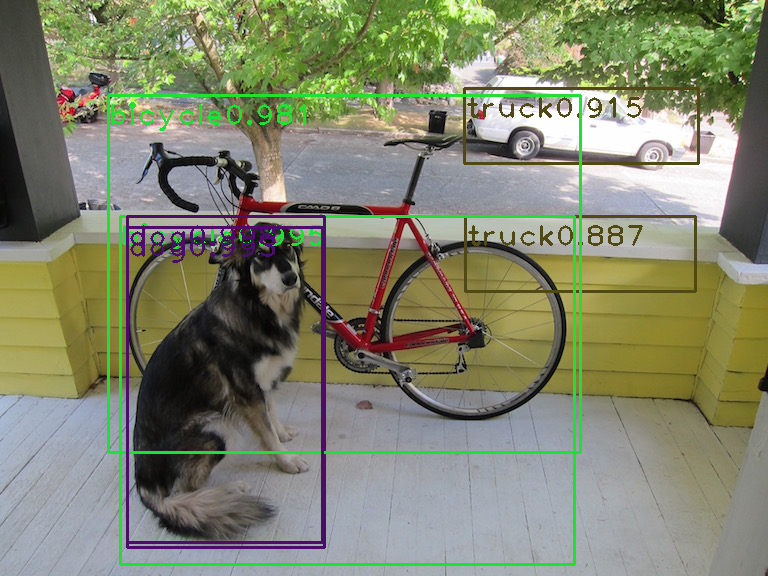

In [133]:
class_ids,confidences,boxes=[],[],[]
output3=yolo_model.forward(out_layers)
for output in output3:
    for vec85 in output:
        scores=vec85[5:]
        class_id=np.argmax(scores)
        confidence=scores[class_id]
        if confidence>0.6: # 신뢰도가 50% 이상인 경우만 취함
            centerx,centery=int(vec85[0]*width),int(vec85[1]*height)  # [0,1] 표현을 영상 크기로 변환
            w,h=int(vec85[2]*width),int(vec85[3]*height)
            x,y=int(centerx-w/2),int(centery-h/2)
            boxes.append([x,y,w,h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
        
indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)
for i in range(len(boxes)):
    if i in indexes:
        x,y,w,h=boxes[i]
        text=str(classes[class_ids[i]])+'%.3f'%confidences[i]
        cv2.rectangle(img,(x,y),(x+w,y+h),colors[class_ids[i]],2)
        cv2.putText(img,text,(x,y+30),cv2.FONT_HERSHEY_PLAIN,2,colors[class_ids[i]],2)
        
from google.colab.patches import cv2_imshow    
cv2_imshow(img)    

cv2.waitKey(0)
cv2.destroyAllWindows()